In [205]:
%load_ext autoreload
%autoreload 2
# from ipython import autoreload
import numpy as np
import causallearn
import random
from clustercausal.algorithms.ClusterPC import ClusterPC
from clustercausal.algorithms.ClusterFCI import ClusterFCI
from clustercausal.clusterdag.ClusterDAG import ClusterDAG
from clustercausal.utils.Utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6']}, \
                         cluster_edges = [('C1', 'C3'), ('C2', 'C3'), ('C2', 'C1')], \
                         cluster_bidirected_edges=[('C1', 'C2')])

In [207]:
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6']}, \
                         cluster_edges = [('C1', 'C3'), ('C2', 'C3')])

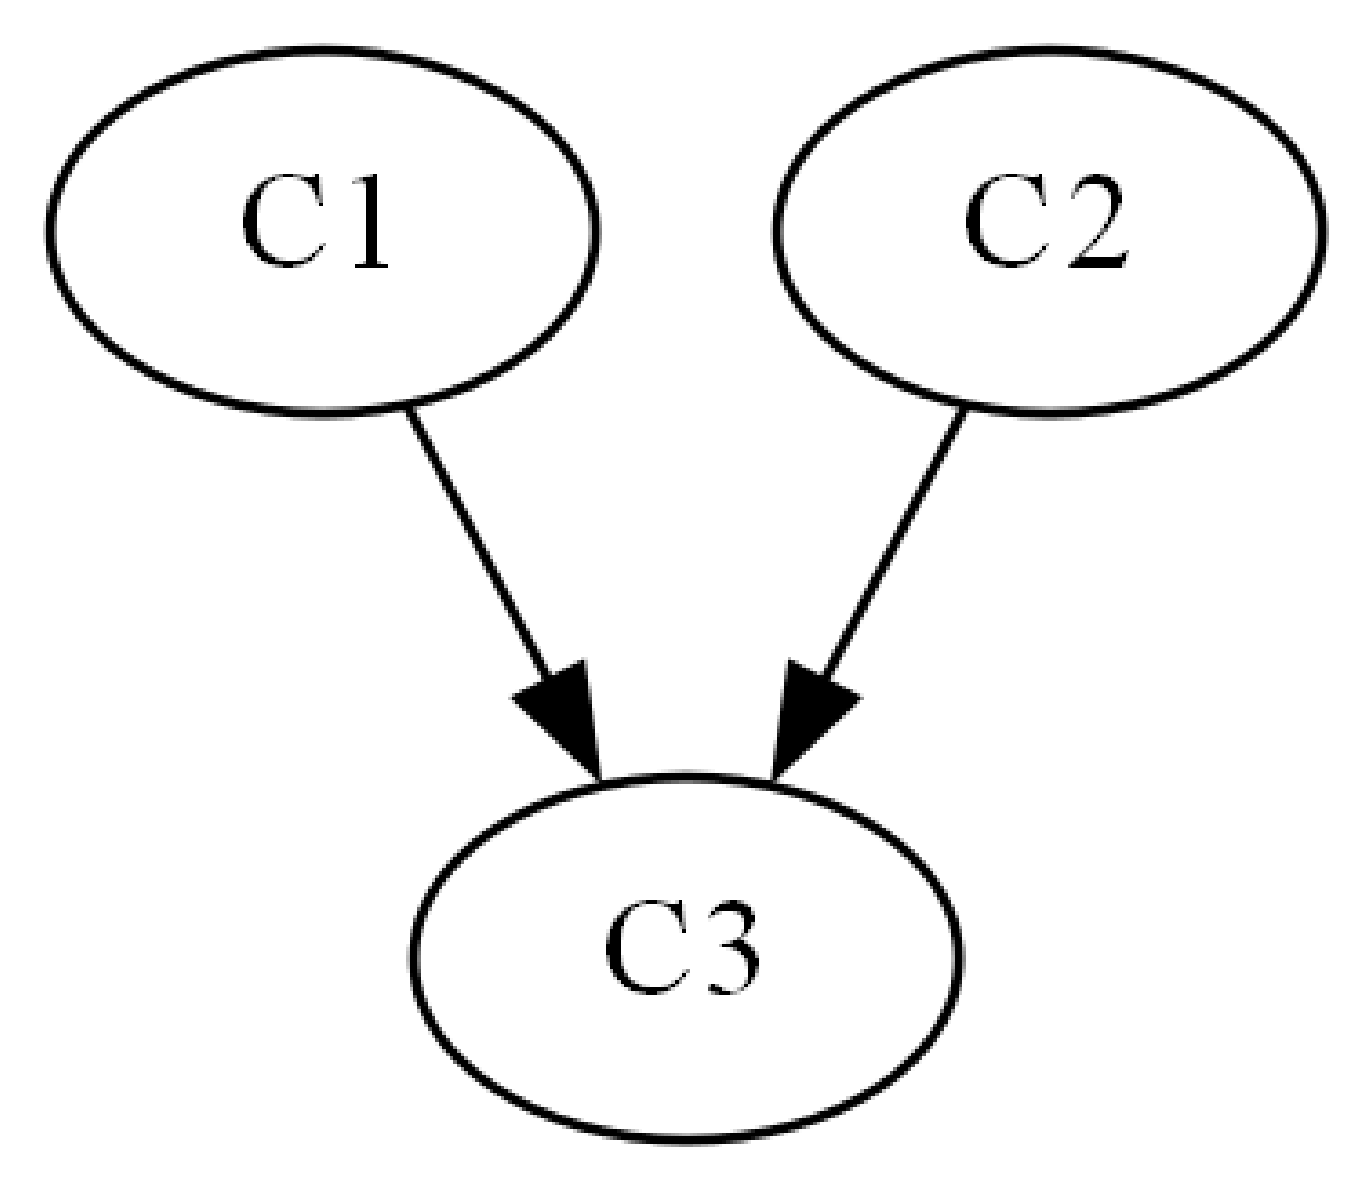

In [208]:
cluster_dag.cluster_graph.draw_pydot_graph()

In [209]:
cluster_dag.cdag_to_mpdag()

In [210]:
cluster_dag.cluster_graph.G.get_graph_edges()[0]

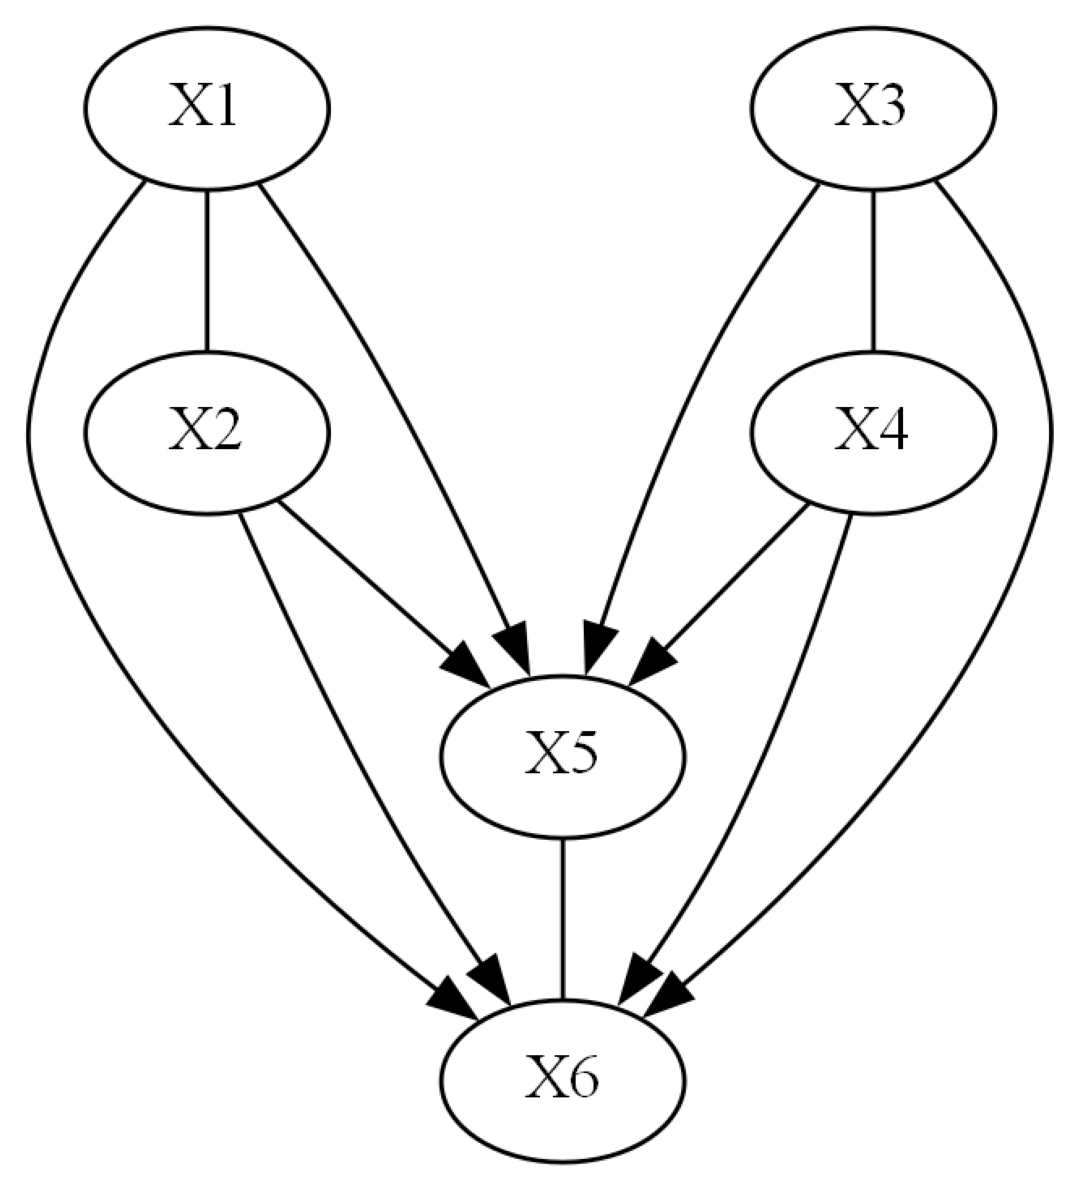

In [211]:
cluster_dag.cg.draw_pydot_graph()

In [212]:
cluster_dag.get_cluster_topological_ordering()

['C1', 'C2', 'C3']

Simple FCI test

In [213]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
import numpy as np
from scipy import linalg
from causallearn.search.ConstraintBased.PC import pc
from causallearn.graph.GeneralGraph import GeneralGraph

from clustercausal.experiments.Simulator import Simulator
from clustercausal.experiments.Evaluator import Evaluator
from clustercausal.algorithms.ClusterPC import ClusterPC
from clustercausal.algorithms.ClusterFCI import ClusterFCI
from clustercausal.clusterdag.ClusterDAG import ClusterDAG
from clustercausal.utils.Utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


### 3 node FCI

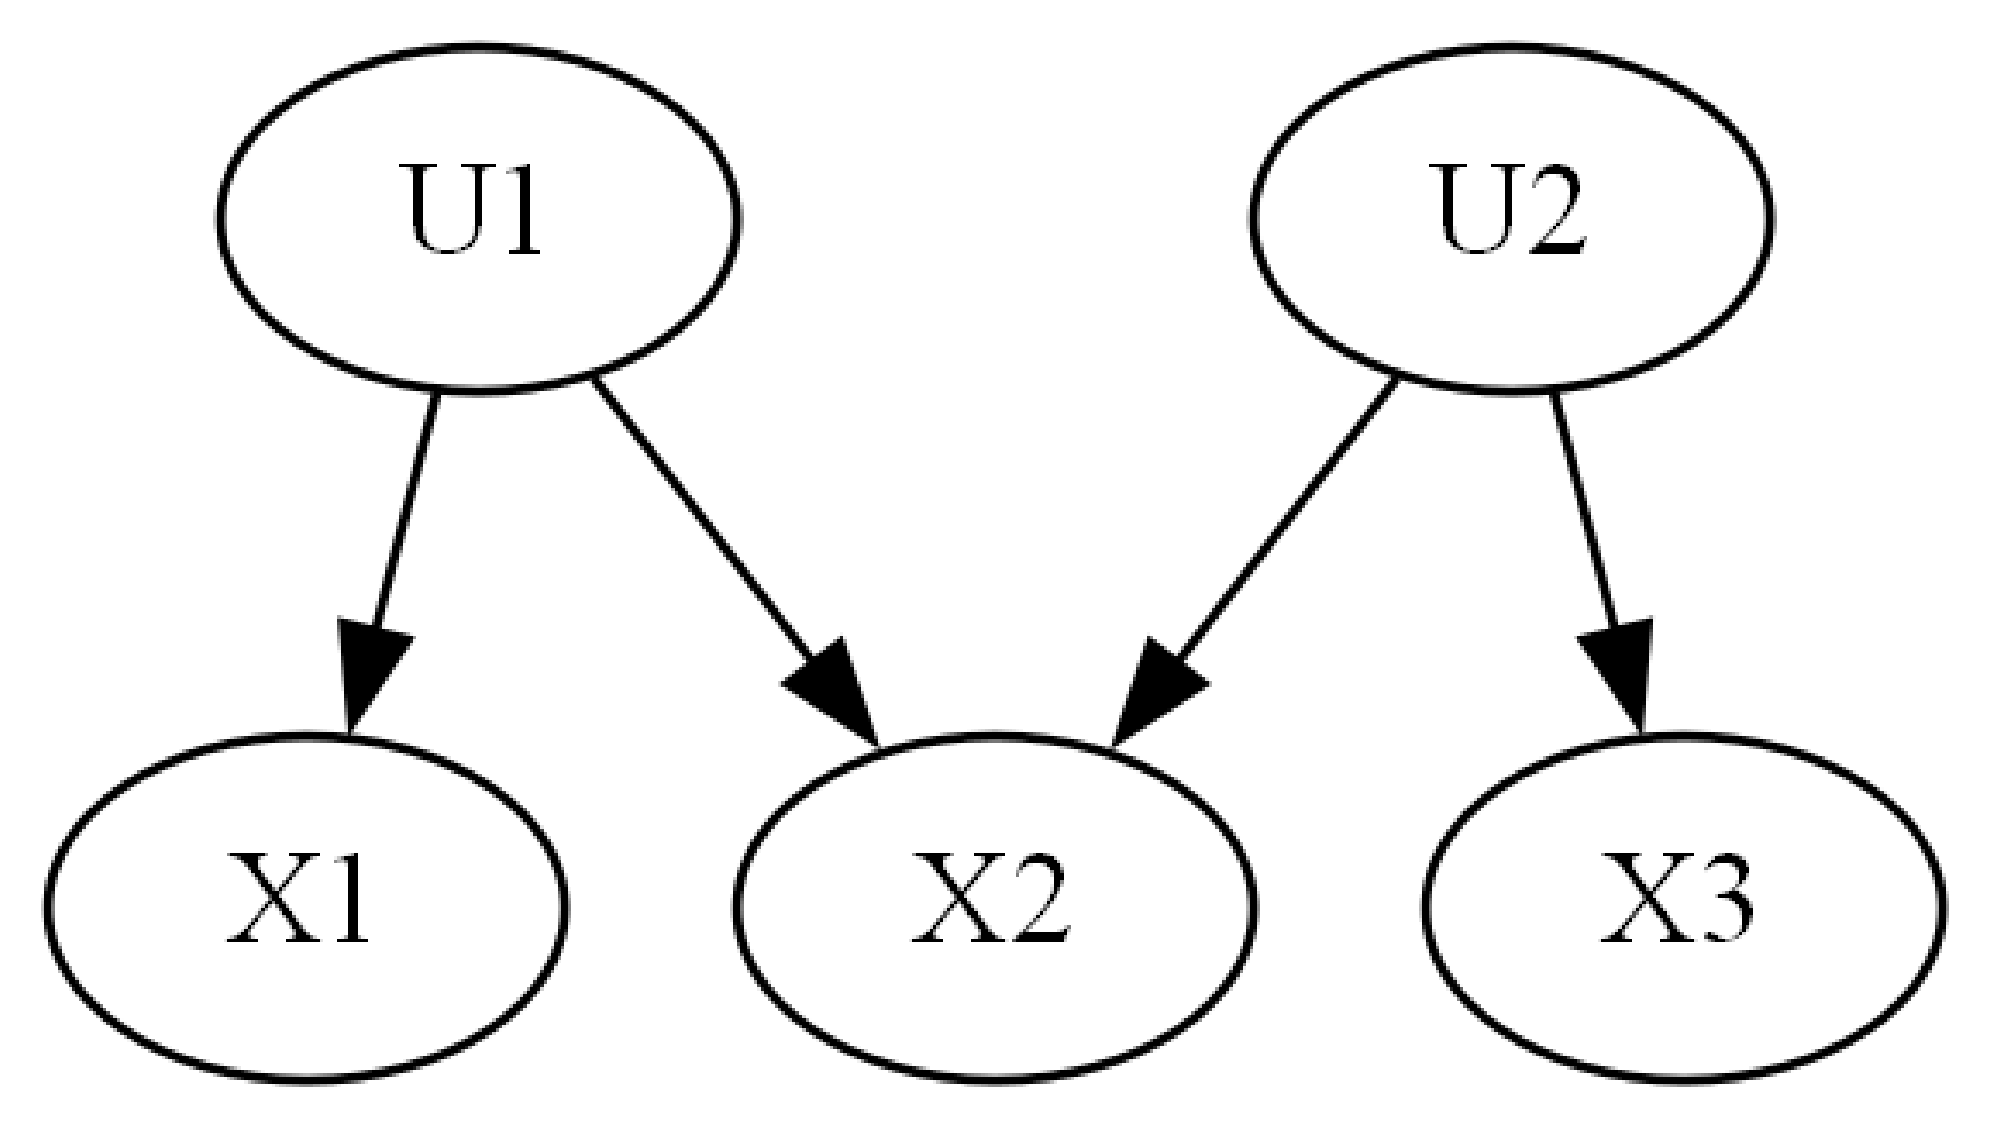

In [300]:
# List of node names
node_names = ["X1", "X2", "X3", "U1", "U2"]

# Parent dictionary
parent_dict = {
    "X1": ["U1"],               # X1 has no parents
    "X2": ["U1", "U2"],           # X2 has X1 as a parent
    "X3": ["U2"],
    "U1": [],
    "U2": []
}

# Call the make_graph function from Utils
truth, W = make_graph(node_names, parent_dict)

truth.draw_pydot_graph()

In [301]:
X = gaussian_data(W, 10000)
alpha = 0.05
X[0,:]

array([ 0.60103517, -0.04557625,  0.90115651,  0.17801539,  0.00166599])

In [302]:
# remove confounders from X
X = X[:,:3]
X

array([[ 0.60103517, -0.04557625,  0.90115651],
       [ 0.94259992, -0.71639121, -2.3279232 ],
       [-0.29025056, -0.14696226,  1.07674667],
       ...,
       [-0.23675502, -0.25420887, -2.33985423],
       [-1.55001839, -5.44745707,  0.04909547],
       [-0.75270399,  0.22252231,  0.09347002]])

In [307]:
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2', 'X3']}, cluster_edges = [])

In [308]:
cluster_fci = ClusterFCI(cluster_dag, X, alpha = 0.05, verbose = False)

In [309]:
cluster_cg, cluster_edges = cluster_fci.run()

C1 phase, Depth=1, working on node 2: 100%|██████████| 3/3 [00:00<00:00, 191.20it/s, duration: 0.03sec]


AttributeError: 'numpy.ndarray' object has no attribute 'get'

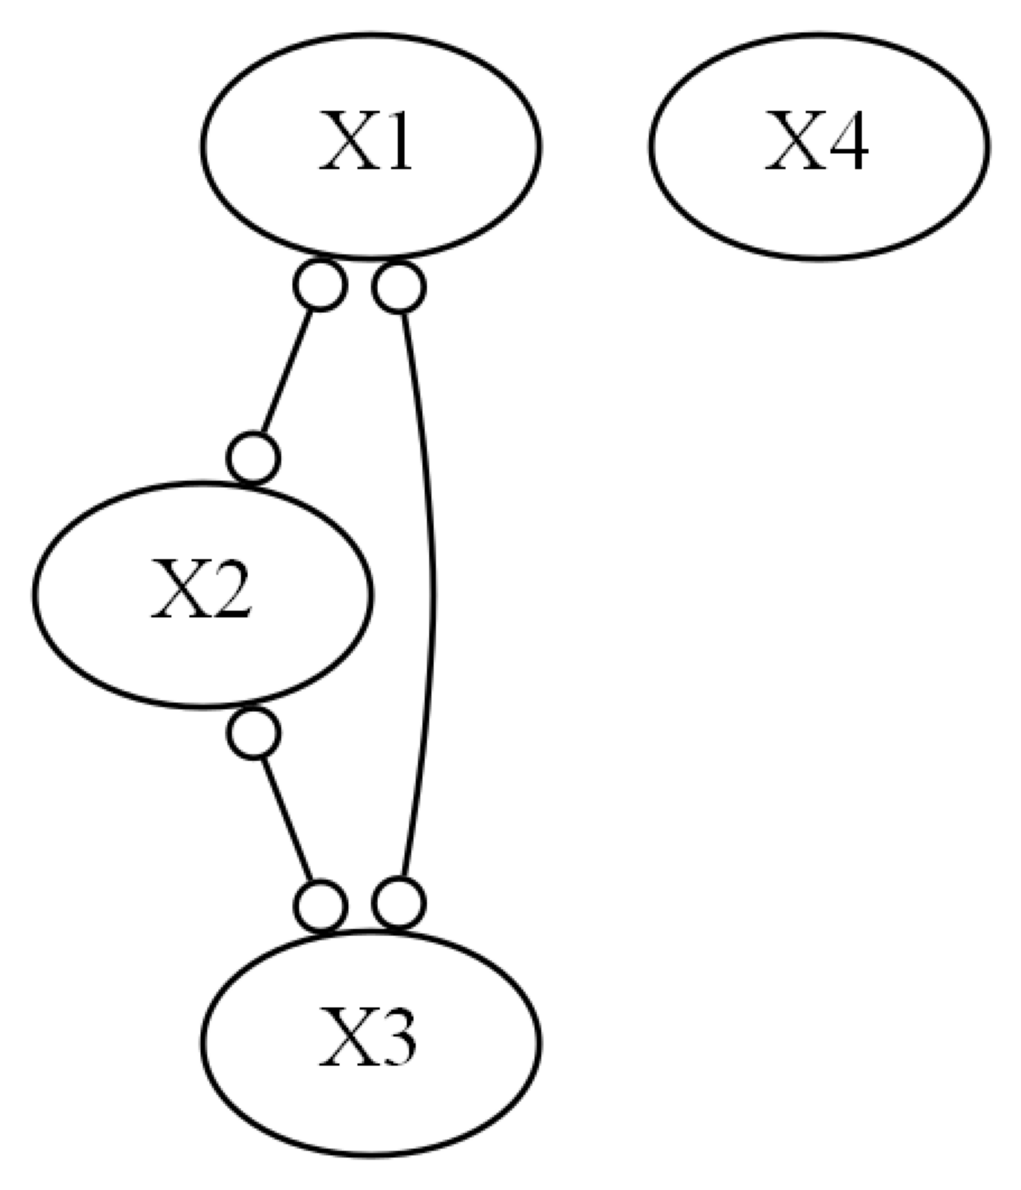

In [310]:
cluster_cg.draw_pydot_graph()

In [ ]:
from causallearn.search.ConstraintBased.FCI import fci

In [ ]:
base_G, base_edges = fci(X, alpha = 0.05, verbose = False)
base_cg = CausalGraph(3, )
node_names = ['X3', 'X4', 'X5']
# for i in range(len(node_names)):
#     base_G.nodes[i].name = node_names[i]
base_G.get_node_names()
base_cg.G = base_G
print("WARNING: FCI doesn't support custom node names!")

Depth=1, working on node 2: 100%|██████████| 3/3 [00:00<00:00, 229.21it/s]

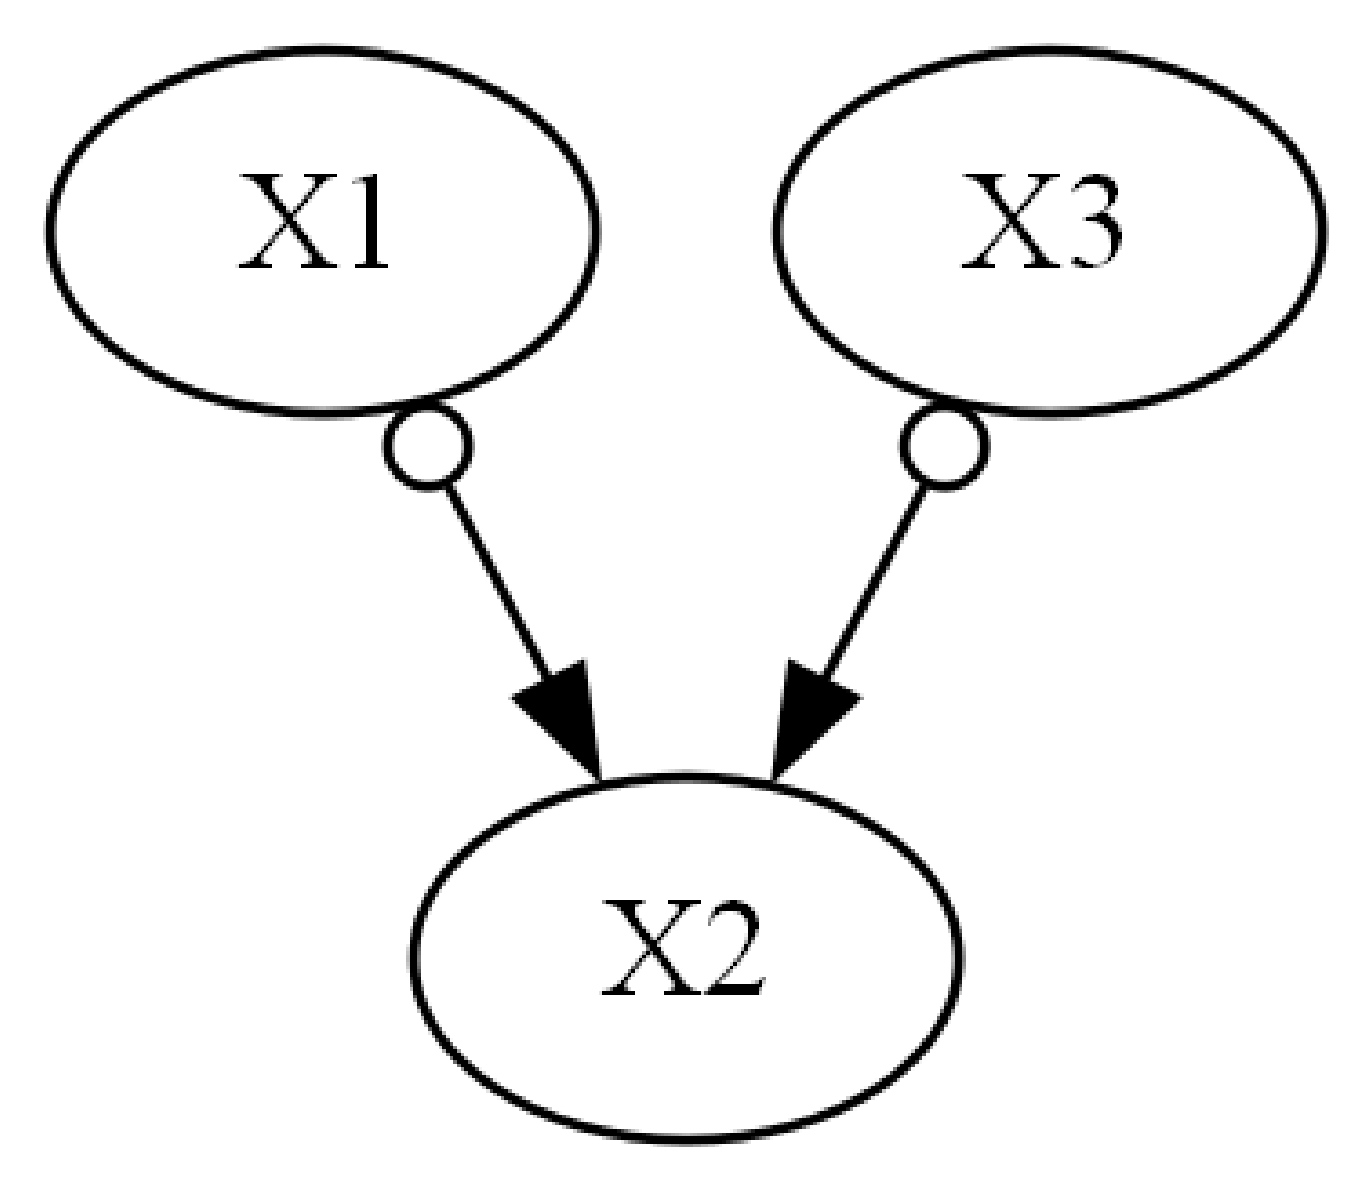

In [ ]:
base_cg.draw_pydot_graph()

### 4 node FCI

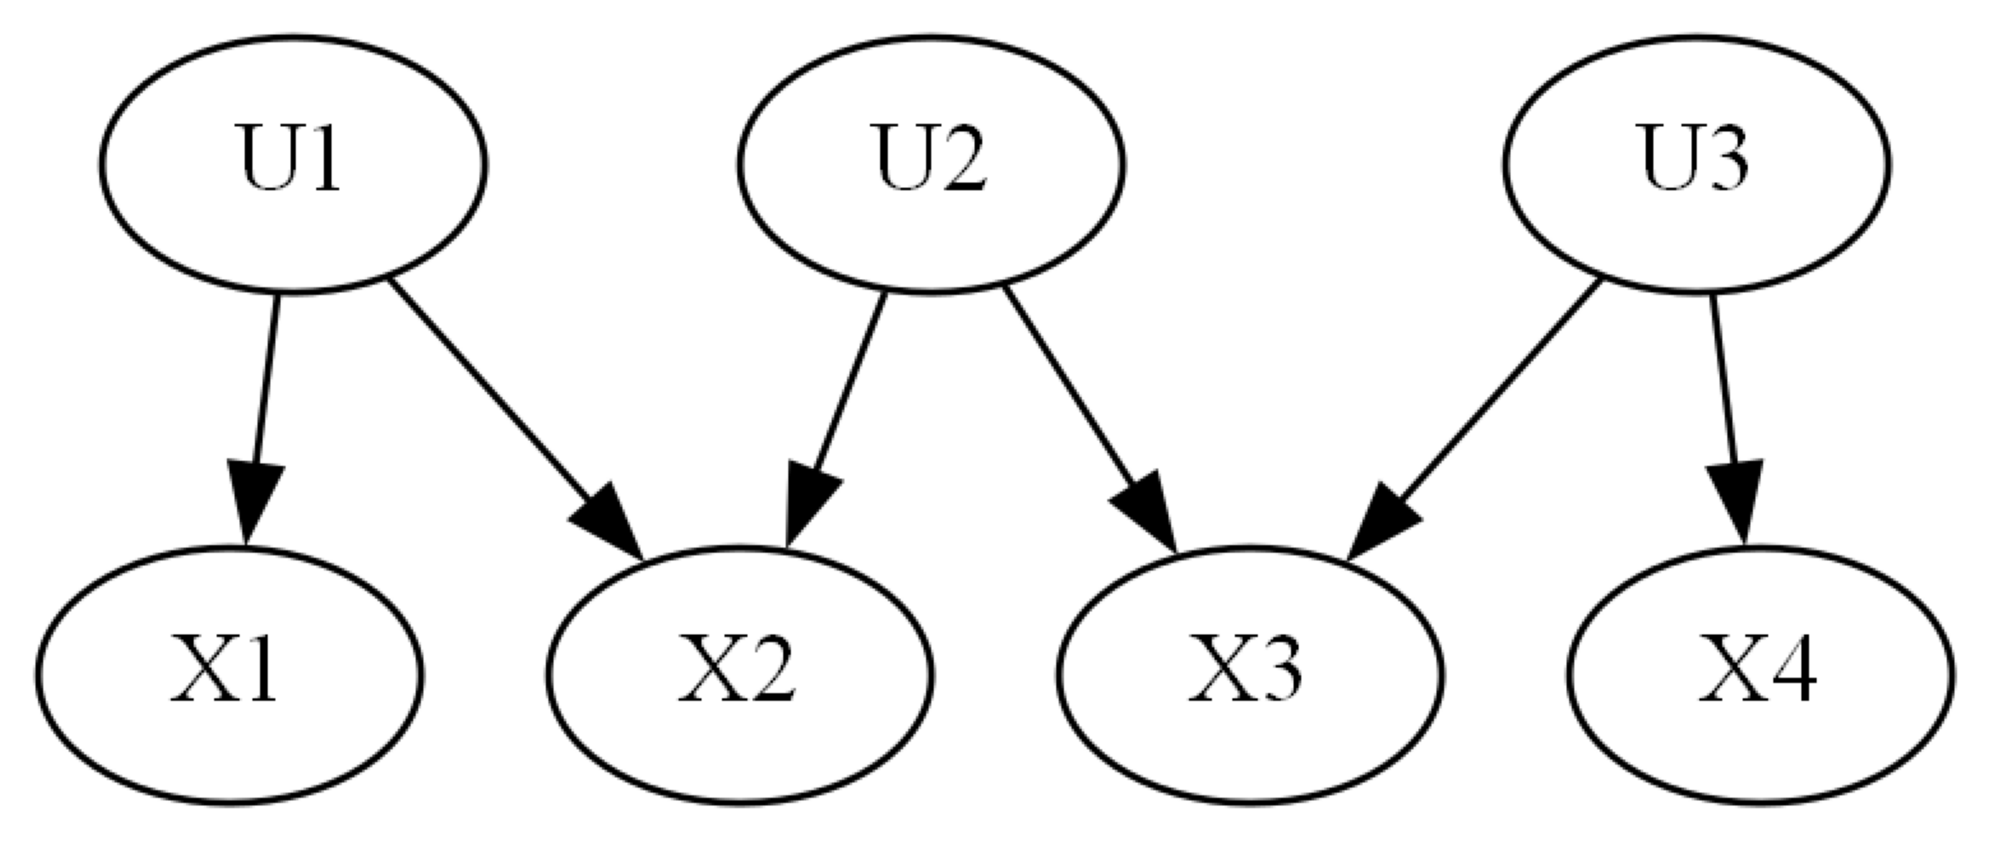

In [ ]:
# List of node names
node_names = ["X1", "X2", "X3", "X4", "U1", "U2", "U3"]

# Parent dictionary
parent_dict = {
    "X1": ["U1"],               # X1 has no parents
    "X2": ["U1", "U2"],           # X2 has X1 as a parent
    "X3": ["U2", "U3"],           # X3 has X1 as a parent
    "X4": ["U3"],
    "U1": [],
    "U2": [],
    "U3": []
}

# Call the make_graph function from Utils
truth, W = make_graph(node_names, parent_dict)

truth.draw_pydot_graph()

In [ ]:
X = gaussian_data(W, 10000)
alpha = 0.05
X[0,:]

array([ 1.19990294,  2.70206257, -0.41171633, -2.21735677,  0.75660927,
        0.51549131, -0.91548842])

In [ ]:
# remove confounders from X
X = X[:,:4]
X

array([[ 1.19990294,  2.70206257, -0.41171633, -2.21735677],
       [-3.67285059, -2.45581212, -0.27204261, -0.09859968],
       [-0.66715064,  0.68444653, -0.75349636,  1.44919149],
       ...,
       [-0.23116752, -0.83195907,  1.51471586,  2.20089587],
       [-0.32460764,  0.93018452,  1.66246133,  3.59400901],
       [-0.44784596, -1.97397279, -1.37941933,  1.59557316]])

In [ ]:
cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2', 'X3', 'X4']}, cluster_edges = [])

In [ ]:
cluster_fci = ClusterFCI(cluster_dag, X, alpha = 0.05, verbose = False)

In [ ]:
cluster_cg, cluster_edges = cluster_fci.run()

C1 phase, Depth=1, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 957.99it/s, duration: 0.02sec]


AttributeError: 'numpy.ndarray' object has no attribute 'get'

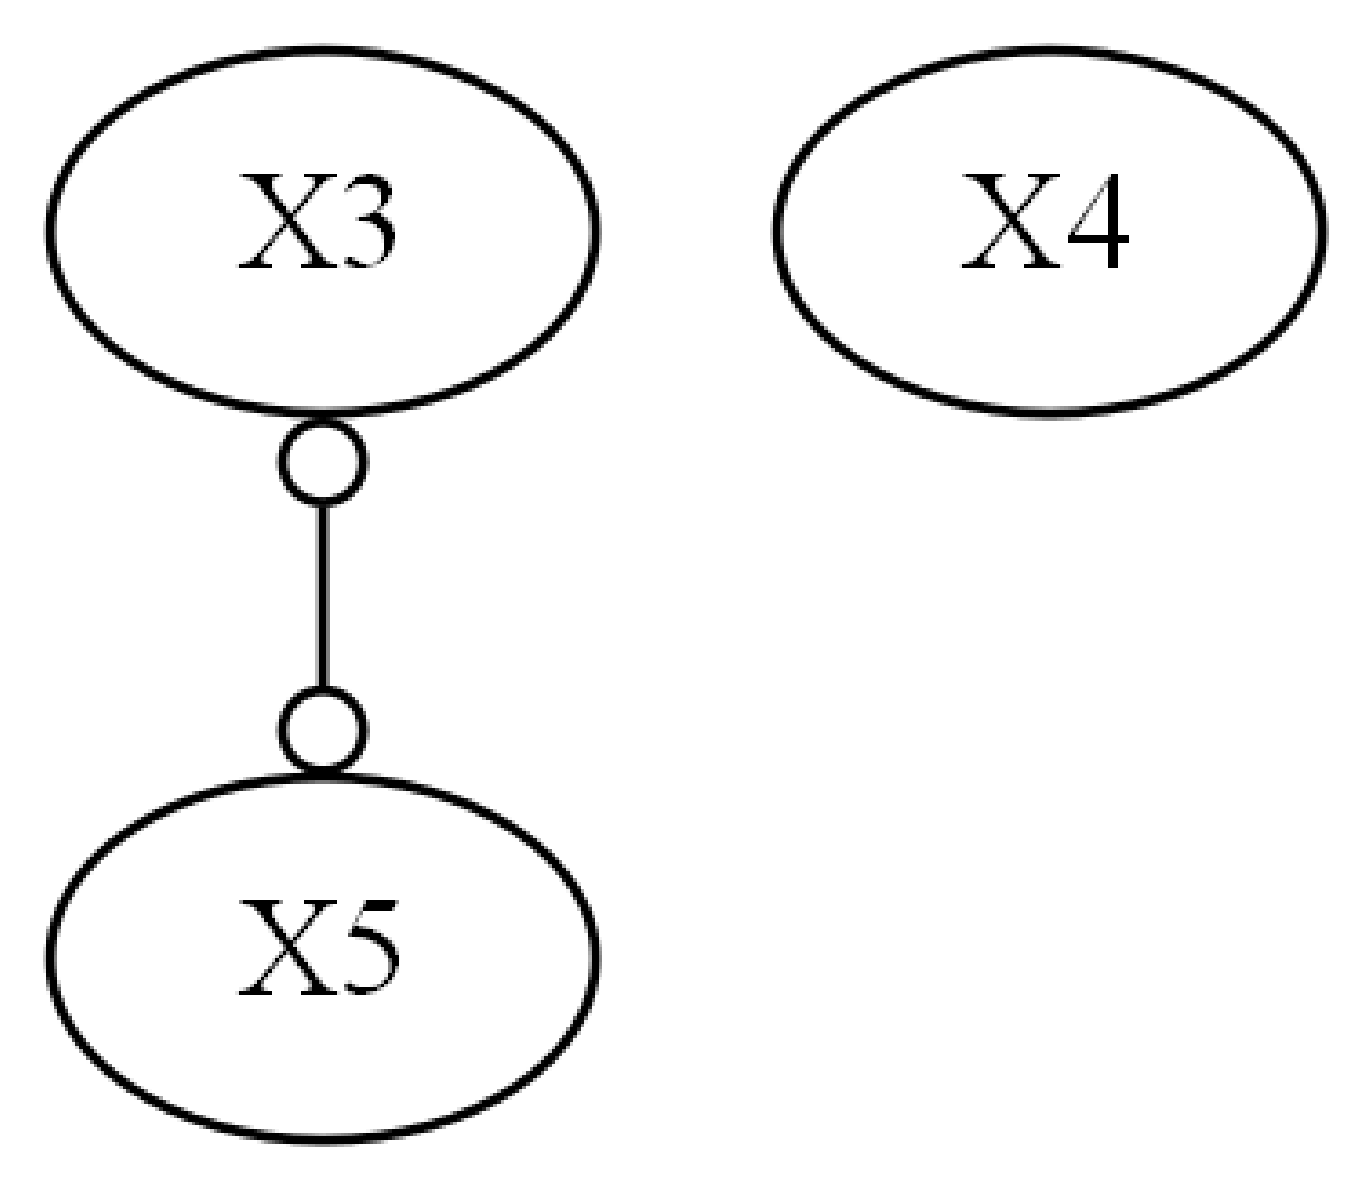

In [ ]:
cluster_cg.draw_pydot_graph()

In [311]:
from causallearn.search.ConstraintBased.FCI import fci

In [312]:
base_G, base_edges = fci(X, alpha = 0.05, verbose = False)
base_cg = CausalGraph(3, )
node_names = ['X3', 'X4', 'X5']
# for i in range(len(node_names)):
#     base_G.nodes[i].name = node_names[i]
base_G.get_node_names()
base_cg.G = base_G
print("WARNING: FCI doesn't support custom node names!")

Depth=1, working on node 2: 100%|██████████| 3/3 [00:00<00:00, 229.21it/s]

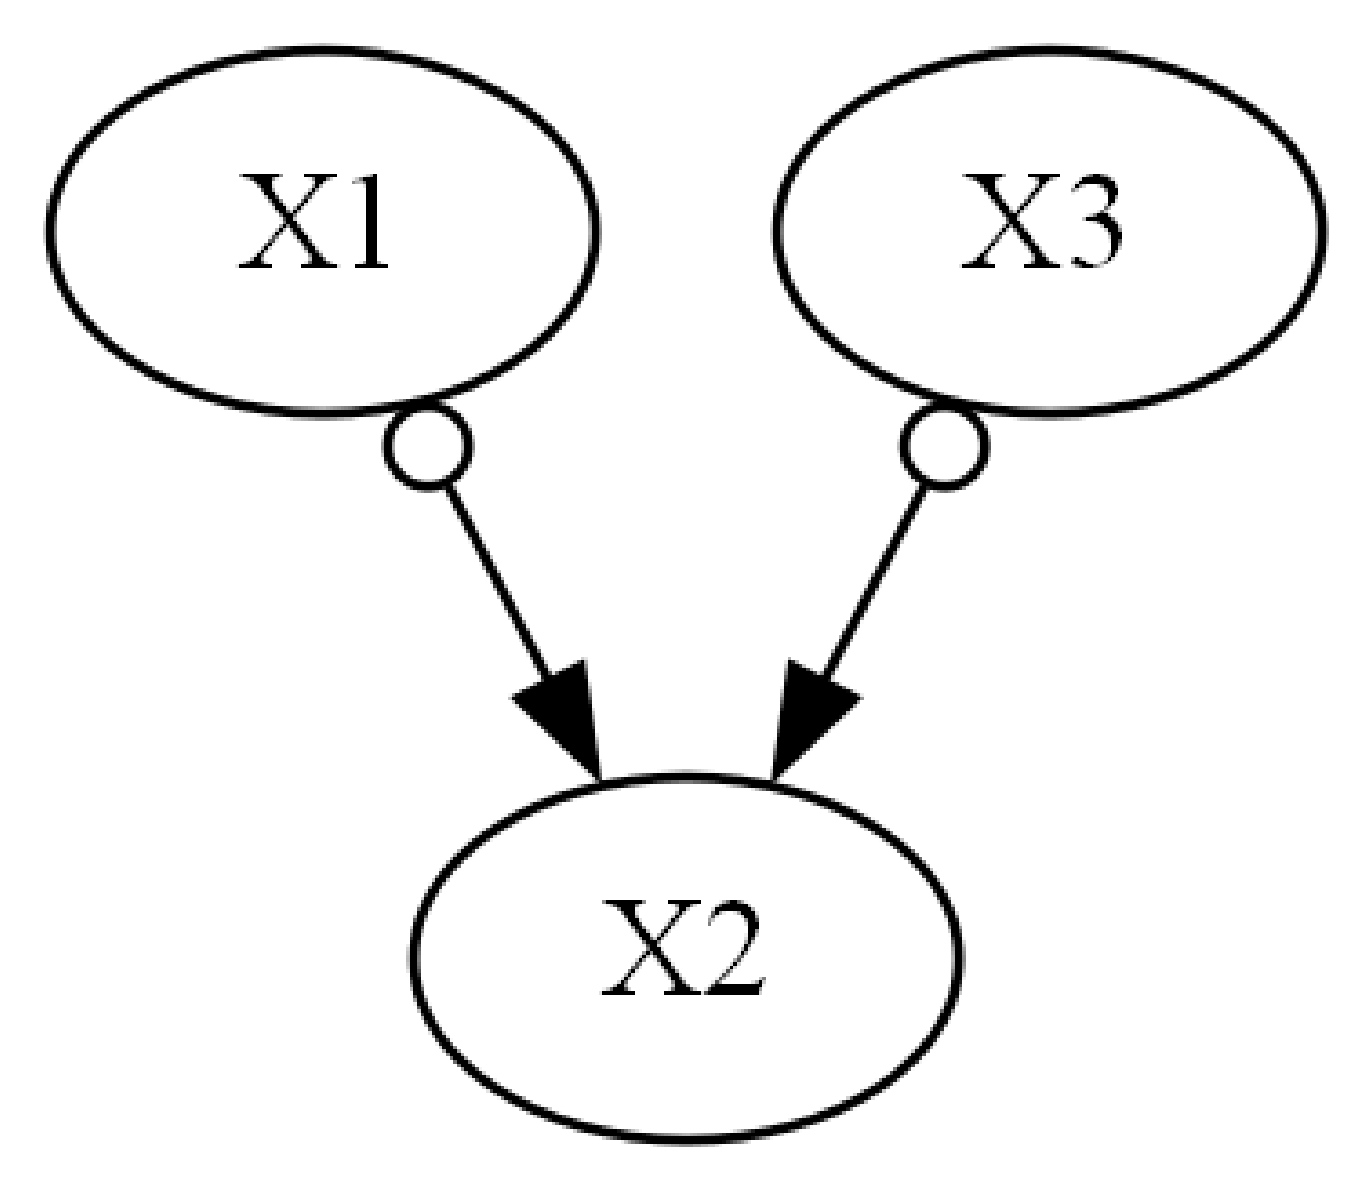

In [313]:
base_cg.draw_pydot_graph()